# TUGAS BESAR
IF5153 Pemrosesan Bahasa Alami

## Model Analisis Promo di Media Sosial (X)
### Model Klasifikasi Promo/Non-Promo - Fine Tuning IndoBERT
Nama : Husnia Munzayana <br>
NIM  : 13521077

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install pandas numpy matplotlib scikit-learn seaborn datasets
!pip install Sastrawi nltk
!pip install transformers torch

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, Trainer, TrainingArguments, EarlyStoppingCallback
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from datasets import Dataset
import seaborn as sns
import re
import nltk
import string
import torch
import os

# Data Loading and Exploration

In [23]:
data = pd.read_csv('https://raw.githubusercontent.com/jejejery/IF5153-Tugas-Besar-Analisis-Promo/refs/heads/main/data/new_dataset_combine_promo_nonpromo_labeled.tsv', sep='\t')

In [24]:
print("\nMissing Values:")
print(data.isnull().sum())

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")

if duplicates > 0:
    print("\nPreview of Duplicate Rows:")
    print(data[data.duplicated()].head())

data = data.drop_duplicates()


Missing Values:
full_text         0
label_promo       0
label_category    0
dtype: int64

Number of Duplicate Rows: 1

Preview of Duplicate Rows:
                                             full_text  label_promo  \
596  Njirrr kode promo gojek udh pada gak bisa kah,...            0   

     label_category  
596              -1  


## Perform Under Sampling

In [25]:
label_counts = data['label_promo'].value_counts()
print("\nLabel counts before undersampling:")
print(label_counts)

min_count = label_counts.min()
label_0 = data[data['label_promo'] == 0]
label_1 = data[data['label_promo'] == 1]

label_0_undersampled = label_0.sample(n=min_count, random_state=42)
label_1_undersampled = label_1.sample(n=min_count, random_state=42)

balanced_data = pd.concat([label_0_undersampled, label_1_undersampled])
data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nLabel counts after undersampling:")
print(data['label_promo'].value_counts())
print(f"\nBalanced dataset size: {data.shape[0]} rows and {data.shape[1]} columns.")


Label counts before undersampling:
label_promo
1    508
0    171
Name: count, dtype: int64

Label counts after undersampling:
label_promo
1    171
0    171
Name: count, dtype: int64

Balanced dataset size: 342 rows and 3 columns.


In [26]:
print("\nBasic Information:")
print(data.info())

print(f"\nDataset size: {data.shape[0]} rows and {data.shape[1]} columns.")


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   full_text       342 non-null    object
 1   label_promo     342 non-null    int64 
 2   label_category  342 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.1+ KB
None

Dataset size: 342 rows and 3 columns.


In [27]:
data.head()

,full_text,label_promo,label_category
0,Aku nemu promo menarik di Lazada nih. Yuk coba...,1,3
1,Rekomendasi Kacamata Road Bike Dengan kacamata...,0,-1
2,Org di komun mau nitip request diskon 20% lagi...,0,-1
3,Kayaknya ini first time gw beli taichan di goj...,0,-1
4,@discountfess nder inimah emg toko yg dulu di ...,0,-1



Label Distribution (Counts and Percentages):
label_promo
1    171
0    171
Name: count, dtype: int64
label_promo
1    50.0
0    50.0
Name: count, dtype: float64


<ipython-input-28-5e603a1b876f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


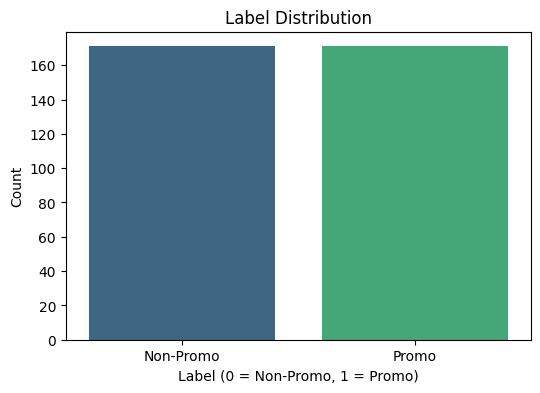

In [28]:
# Label distribution
label_counts = data['label_promo'].value_counts()
print("\nLabel Distribution (Counts and Percentages):")
print(label_counts)
print(label_counts / len(data) * 100)

# Visualize
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title("Label Distribution")
plt.xlabel("Label (0 = Non-Promo, 1 = Promo)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Non-Promo', 'Promo'])
plt.show()


Word Count Statistics:
count    342.000000
mean      26.374269
std       12.325509
min        3.000000
25%       17.000000
50%       24.000000
75%       36.000000
max      109.000000
Name: word_count, dtype: float64


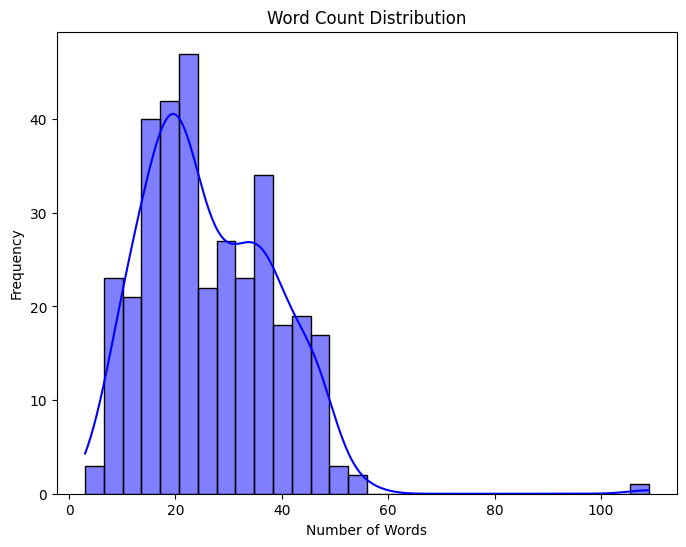

In [29]:
# Add a column for word count
data['word_count'] = data['full_text'].apply(lambda x: len(x.split()))

print("\nWord Count Statistics:")
print(data['word_count'].describe())

# Visualize word count distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['word_count'], bins=30, kde=True, color='blue')
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


Most Common Words:
[('di', 185), ('promo', 130), ('diskon', 118), ('dan', 95), ('beli', 94), ('murah', 77), ('untuk', 66), ('Harga', 59), ('ada', 58), ('harga', 55), ('gojek', 53), ('lebih', 52), ('Produk:', 49), ('yang', 46), ('yg', 46), ('Promo', 46), ('dari', 42), ('ga', 41), ('kalo', 41), ('bisa', 37)]


<ipython-input-30-9fcb808b5312>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


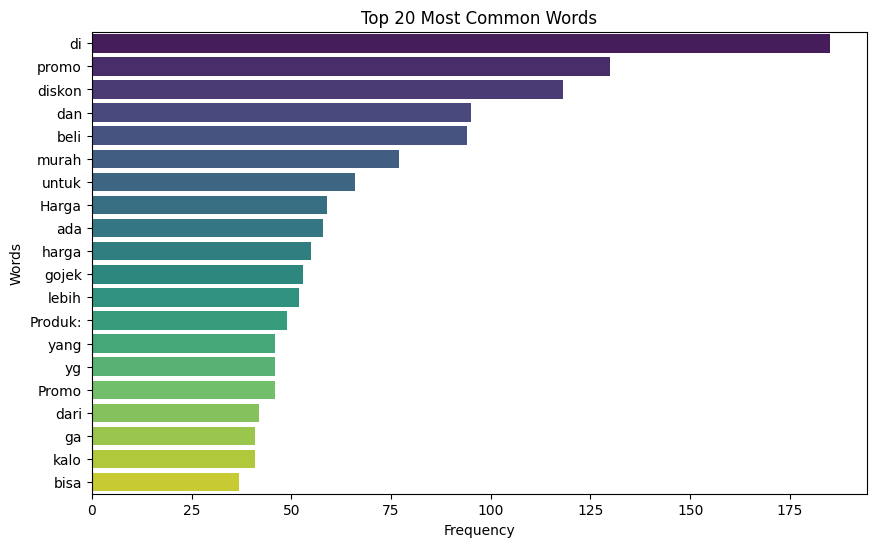

In [30]:
from collections import Counter

# Tokenize and count words
all_words = ' '.join(data['full_text']).split()
most_common_words = Counter(all_words).most_common(20)

print("\nMost Common Words:")
print(most_common_words)

# Visualize most common words
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title("Top 20 Most Common Words")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

# Data Pre-Processing

In [31]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

factory = StemmerFactory()
stemmer = factory.create_stemmer()

stopwords_id = set(stopwords.words('indonesian'))

def process_text(text):
    # Lowercase
    text = text.lower()

    # Entity masking
    # URLs Masking
    text = re.sub(r'http\S+|www\S+', '_url_', text)

    # Usernames Masking
    text = re.sub(r'@\w+', '_username_', text)

    # Hashtags Masing
    text = re.sub(r'#\w+', '_hashtag_', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Stopwords elimination
    text = ' '.join([word for word in text.split() if word not in stopwords_id])

    return text

def preprocess_texts(texts):
    processed_texts = []
    for text in tqdm(texts, desc="Preprocessing Texts"):
        tokens = process_text(text)
        processed_texts.append(tokens)
    return processed_texts

tqdm.pandas()
data['clean_tweet'] = data['full_text'].progress_apply(process_text)

print("\nPreview data after preprocessing:")
print(data.dtypes)
print(data.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 342/342 [00:00<00:00, 28824.51it/s]


Preview data after preprocessing:
full_text         object
label_promo        int64
label_category     int64
word_count         int64
clean_tweet       object
dtype: object
                                           full_text  label_promo  \
0  Aku nemu promo menarik di Lazada nih. Yuk coba...            1   
1  Rekomendasi Kacamata Road Bike Dengan kacamata...            0   
2  Org di komun mau nitip request diskon 20% lagi...            0   
3  Kayaknya ini first time gw beli taichan di goj...            0   
4  @discountfess nder inimah emg toko yg dulu di ...            0   

   label_category  word_count  \
0               3          34   
1              -1          29   
2              -1          16   
3              -1          26   
4              -1          39   

                                         clean_tweet  
0  nemu promo menarik lazada nih yuk coba lihat n...  
1  rekomendasi kacamata road bike kacamata road b...  
2  org komun nitip request diskon 20 org ga tau

In [32]:
# Tokenization
model_name = "indobenchmark/indobert-base-p2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["clean_tweet"],
        padding="max_length",
        truncation=True,
        max_length=512,
    )

hf_dataset = Dataset.from_pandas(data)
hf_dataset = hf_dataset.map(tokenize_function, batched=True)
hf_dataset = hf_dataset.map(lambda x: {'label': x['label_promo']})
os.environ["WANDB_MODE"] = "offline"

Map:   0%|          | 0/342 [00:00<?, ? examples/s]

Map:   0%|          | 0/342 [00:00<?, ? examples/s]

## Data Splitting

In [33]:
hf_dataset = hf_dataset.train_test_split(
    test_size=0.2,
    seed=42
)

train_val_dataset = hf_dataset['train'].train_test_split(
    test_size=0.25,
    seed=42
)

train_dataset = train_val_dataset['train']
val_dataset = train_val_dataset['test']
test_dataset = hf_dataset['test']

print(f"Data Train: {len(train_dataset)}, Data Validation: {len(val_dataset)}, Data Test: {len(test_dataset)}")


Data Train: 204, Data Validation: 69, Data Test: 69


In [34]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=1)

    report = classification_report(labels, preds, target_names=['Non-Promo', 'Promo'], output_dict=True)

    acc = accuracy_score(labels, preds)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Non-Promo', 'Promo']))

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

# Modelling

In [35]:
# Load Model
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="accuracy",
    seed=42,
)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-35-94454eb300c5>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [36]:
#Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.311451,0.927536,0.927842,0.937888,0.927536
2,0.419800,0.166714,0.971014,0.971101,0.972826,0.971014
3,0.176000,0.112370,0.971014,0.971101,0.972826,0.971014
4,0.176000,0.096250,0.971014,0.971101,0.972826,0.971014



Classification Report:
              precision    recall  f1-score   support

   Non-Promo       1.00      0.87      0.93        39
       Promo       0.86      1.00      0.92        30

    accuracy                           0.93        69
   macro avg       0.93      0.94      0.93        69
weighted avg       0.94      0.93      0.93        69


Classification Report:
              precision    recall  f1-score   support

   Non-Promo       1.00      0.95      0.97        39
       Promo       0.94      1.00      0.97        30

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
weighted avg       0.97      0.97      0.97        69


Classification Report:
              precision    recall  f1-score   support

   Non-Promo       1.00      0.95      0.97        39
       Promo       0.94      1.00      0.97        30

    accuracy                           0.97        69
   macro avg       0.97      0.97      0.97        69
we

TrainOutput(global_step=28, training_loss=0.24249017238616943, metrics={'train_runtime': 110.2895, 'train_samples_per_second': 9.248, 'train_steps_per_second': 0.317, 'total_flos': 214698621173760.0, 'train_loss': 0.24249017238616943, 'epoch': 4.0})

In [37]:
# Evaluate the Model
test_results = trainer.evaluate(test_dataset)
print("\nTest Results:", test_results)


Classification Report:
              precision    recall  f1-score   support

   Non-Promo       0.91      0.97      0.94        33
       Promo       0.97      0.92      0.94        36

    accuracy                           0.94        69
   macro avg       0.94      0.94      0.94        69
weighted avg       0.94      0.94      0.94        69


Test Results: {'eval_loss': 0.19468702375888824, 'eval_accuracy': 0.9420289855072463, 'eval_f1': 0.9420533430763609, 'eval_precision': 0.9436609426379248, 'eval_recall': 0.9420289855072463, 'eval_runtime': 2.1314, 'eval_samples_per_second': 32.374, 'eval_steps_per_second': 1.408, 'epoch': 4.0}


In [38]:
output_dir = '/content/drive/MyDrive/TUGAS KULIAH/TUGAS BESAR NLP/MODEL/Promo-Non Classification/IndoBERT-UnderSampling'

os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.
